<h1>Audio deepfake recognition</h1>







In [80]:
import os
import numpy as np
import librosa
import tensorflow as tf
import time


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical



utente = 0 #0 = Matteo; 1 = Greta

# Define paths and parameters
if utente == 0 :
    DATASET_PATH = "/mnt/c/Users/matte/Desktop/LA/ASVspoof2019_LA_train/flac"
    LABEL_FILE_PATH = "/mnt/c/Users/matte/Desktop/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
    TEST_DATASET_PATH = "/mnt/c/Users/matte/Desktop/LA/ASVspoof2019_LA_dev/flac"
    PROTOCOL_FILE_PATH = "/mnt/c/Users/matte/Desktop/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
else:
    DATASET_PATH = "/mnt/c/Users/Greta/Desktop/LA/ASVspoof2019_LA_train/flac"
    LABEL_FILE_PATH = "/mnt/c/Users/Greta/Desktop/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
    TEST_DATASET_PATH = "/mnt/c/Users/Greta/Desktop/LA/ASVspoof2019_LA_dev/flac"
    PROTOCOL_FILE_PATH = "/mnt/c/Users/Greta/Desktop/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

    

#DATASET_PATH = "./drive/MyDrive/DFProj_link/LA/ASVspoof2019_LA_train/flac"
#LABEL_FILE_PATH = "./drive/MyDrive/DFProj_link/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"




TRAIN_VAL_SPLIT = 0.7
TEST_SAMPLE_SIZE = 25000#25000


NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
# Define the hop length
HOP_LENGTH = 512  # Adjust this value based on your needs

MODEL_PATH = "Models/audio_classifier2.keras"  # Path to the saved model file
MAX_TIME_STEPS = 109 #Maximum number of time steps (frames) for the Mel spectrograms

print('Complete')

Complete


<h1>MODEL GENERATION</h1>

<h2>Dataset loading</h2>

The current dataset from ASVspoof2019.cm.train is composed of more than 25000 samples but only 2580 of them are bonafide samples. The others are spoof audio from different models.

To balance the dataset:
<ol>
    <li>Load the 2580 real audio</li>
    <li>Load the remaining spoof audio</li>
    <li>Shuffle the spoof audio to avoid exluding sample classes</li>
    <li>Take only 2580 spoof sample</li>
    <li>Concatenate the real samples and the fake ones and the shuffle them</li>
</ol>


We will first load the list of files and lables from Protocol files to speed up the process

In [2]:
from sklearn.utils import shuffle

labels = {}

#load protocols file with train file list
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

files = []
Y = []

#read each line and save file name and label
for line in lines:
    parts = line.strip().split()
    files.append(parts[1])
    label = 1 if parts[-1] == "bonafide" else 0
    Y.append(label)

#take the first 2580 files and labels that are real samples
files_true = files[:2580] #files bonafide
Y_true = Y[:2580]
#take the reamaing fake samples and suffle them
files_false,Y_false = shuffle(files[2581:],Y[2581:])
#take only the 2580 fake samples and labels
files_false = files_false[:2580]
Y_false = Y_false[:2580]

#concatenate real and false samples
files = files_true + files_false
Y = Y_true + Y_false
#shuffle the dataset
files, Y = shuffle(files,Y)

print('Complete')

Complete


<h2>Load and process audio files</h2>

For each file in the list builded we load the corresponding audio files and compute the mel spectogram that will be used to train the model

In [3]:

X = []

start_time = time.time()

## Load files 
for file_name in files:
    ## Combines the base path 'DATASET_PATH' with the file name and extension '.flac' to get the full path of the file
    file_path = os.path.join(DATASET_PATH, file_name + '.flac')
  
    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Check all spectrograms have the same time steps (width)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X.append(mel_spectrogram)
    

end_time = time.time()  # Fine misurazione
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.6f} s")
print('Complete')

Time elapsed: 401.490922 s
Complete


<h2>Data split</h2>

We will split the samples for train and validation

In [4]:
X = np.array(X)
Y = np.array(Y)

#Convert the label 'y' in the format "one-hot encoding" for the classification 
Y_encoded = to_categorical(Y, NUM_CLASSES)

#Find the index to split the data for training and validation
split_index = int(TRAIN_VAL_SPLIT * len(X))

print('Training samples: ',split_index)
print('Validation samples: ',len(X)-split_index)

#Divide input dataset in 'X_Train', 'X_Val' and 'Y_Train', 'Y_Val'  
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y_encoded[:split_index], Y_encoded[split_index:]

print('Complete')

Training samples:  3611
Validation samples:  1549
Complete


<h2>Class Distribution</h2>

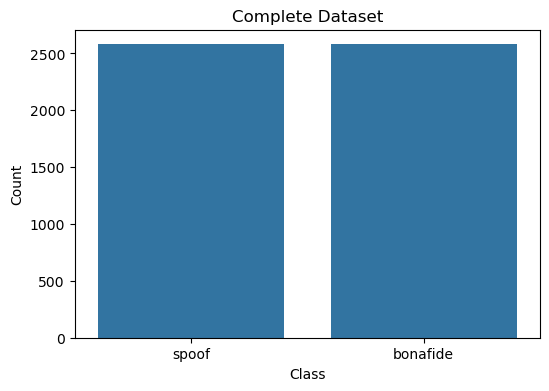

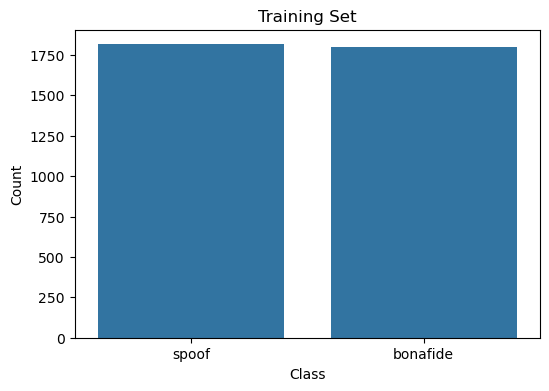

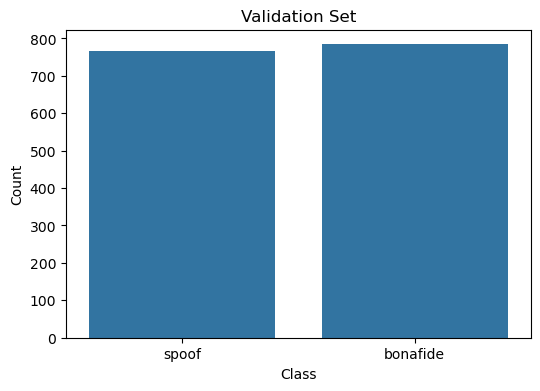

Complete


In [5]:
# Plot bar chart of class distribution

import seaborn as sns
import matplotlib.pyplot as plt


LABELS = ['spoof', 'bonafide']

plt.figure(figsize=(6, 4))
sns.countplot(x=Y)
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Complete Dataset')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=Y[:split_index])
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Set')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=Y[split_index:])
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Validation Set')
plt.show()
print('Complete')

<h2>Mel Spectogram</h2>

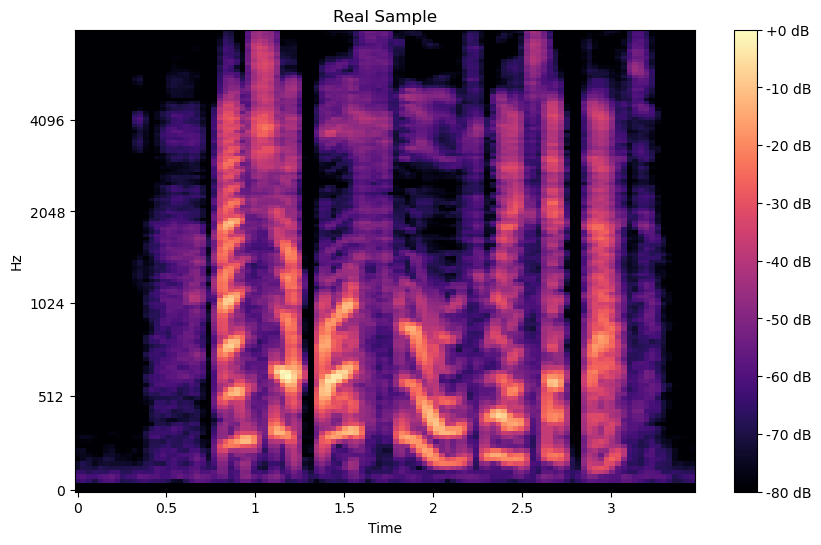

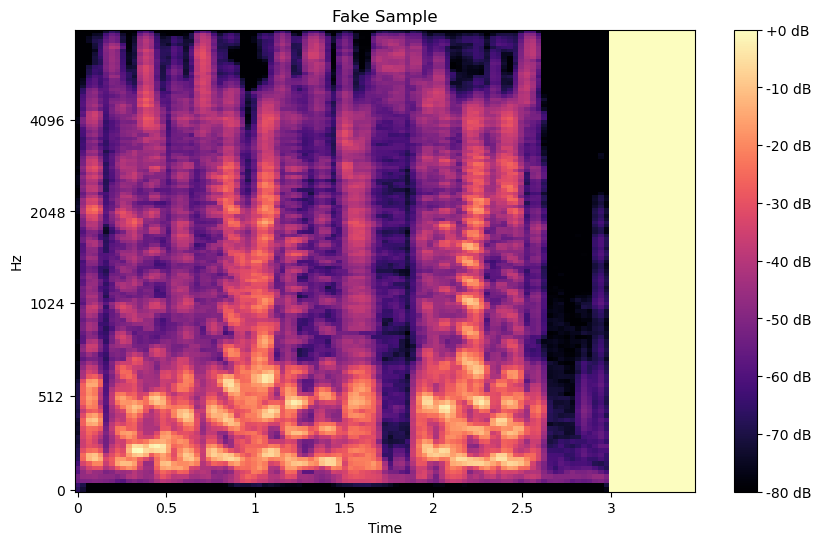

In [6]:
index_real = 0
index_fake = 0

#Find one real sample audio
for i, label in enumerate(Y):
    if label == 1:
        index_real = i
        break

#Find one fake sample audio
for i, label in enumerate(Y):
    if label == 0:
        index_fake = i
        break

# Plot the Mel spectrogram of real sample
plt.figure(figsize=(10, 6))
librosa.display.specshow(X[index_real], x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Real Sample')
plt.show()


# Plot the Mel spectrogram of fake sample
plt.figure(figsize=(10, 6))
librosa.display.specshow(X[index_fake], x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Fake Sample')
plt.show()

<h2>Model definition</h2>

In [57]:
start_time = time.time()

# Define CNN model architecture and specify the input shape for the CNN:
# - N_MELS: Number of Mel frequency bins (height of the input)
# - X_train.shape[2]: Width of the input 
# - 1: Number of channels (e.g., grayscale for spectrograms)
input_shape = (N_MELS, X_train.shape[2], 1)  
model_input = Input(shape=input_shape)
# First convolutional layer:
# - 32 filters, each with a 3x3 kernel.
# - ReLU activation function for introducing non-linearity
x = Conv2D(32, kernel_size=(5,5), activation='relu')(model_input)
x = BatchNormalization()(x)
# First max-pooling layer:
# - Reduces the spatial dimensions of the feature maps by half using a 2x2 pooling window
x = MaxPooling2D(pool_size=(2, 2))(x)
# Second convolutional layer:

# - 64 filters, each with a 3x3 kernel
# - ReLU activation for non-linearity
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
# Second max-pooling layer:
# - Further reduces the spatial dimensions of the feature maps by half
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flattening layer:
# - Converts the 2D feature maps into a 1D vector to prepare it for fully connected layers
x = Flatten()(x)
# Fully connected layer:
# - 128 neurons with ReLU activation
x = Dense(128, activation='relu')(x)
# Dropout layer:
# - Randomly drops 50% of the neurons to prevent overfitting during training
x = Dropout(0.5)(x)
# Output layer:
# - NUM_CLASSES: Number of target classes for classification
# - Softmax activation to output class probabilities
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

end_time = time.time()  # Fine misurazione
elapsed_time = end_time - start_time
print(f"Tempo trascorso: {elapsed_time:.6f} secondi")
print('Complete')

Tempo trascorso: 0.090430 secondi
Complete


<h2>Training</h2>

In [58]:
start_time = time.time()
# Create the CNN model with 'model_input' (input layer previously defined)and 'model_output' (final output layer with predictions)
model = Model(inputs=model_input, outputs=model_output)
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

end_time = time.time()  # Fine misurazione
elapsed_time = end_time - start_time
print(f"Tempo trascorso: {elapsed_time:.6f} secondi")
print('Complete')

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 420ms/step - accuracy: 0.6096 - loss: 2.7035 - val_accuracy: 0.7682 - val_loss: 0.5101
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 389ms/step - accuracy: 0.7914 - loss: 0.4501 - val_accuracy: 0.8864 - val_loss: 0.3070
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 467ms/step - accuracy: 0.8864 - loss: 0.2592 - val_accuracy: 0.9258 - val_loss: 0.1823
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - accuracy: 0.9242 - loss: 0.1730 - val_accuracy: 0.9580 - val_loss: 0.1103
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.9405 - loss: 0.1434 - val_accuracy: 0.9496 - val_loss: 0.1388
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 420ms/step - accuracy: 0.9509 - loss: 0.1246 - val_accuracy: 0.9781 - val_loss: 0.0794
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 409ms/step - accuracy: 0.9641 - loss: 0.0941 - val_accuracy: 0.9335 - val_loss: 0.1653
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 417ms/step - accuracy: 0.9725 - loss: 0

<h2>Model Saving</h2>

In [69]:
# saving the model
model.save(MODEL_PATH)

print('Complete')

Complete


<h1>DATA VISUALIZATION</h1>

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

<h2>Parsing and Shuffling True Labels for Dataset Preparation</h2>

In [82]:
# Dictionary to store true labels for each file

#load protocols file with train file list
with open(PROTOCOL_FILE_PATH, 'r') as true_label_file:
    lines = true_label_file.readlines()

test_files = []
Y_test = []

#read each line and save file name and label
for line in lines:
    parts = line.strip().split()
    test_files.append(parts[1])
    label = 1 if parts[-1] == "bonafide" else 0
    Y_test.append(label)

#shuffle the dataset
test_files, Y_test = shuffle(test_files,Y_test)
#limit the size of the dataset for time contraints
test_files = test_files[0:TEST_SAMPLE_SIZE]
Y_test = Y_test[0:TEST_SAMPLE_SIZE]




# Now 'true_labels' contains the true labels for each file
#true_labels
print('Complete')

Complete


<h2>Loading, Preprocessing, and Normalizing Mel Spectrograms for Test Audio Files</h2>

In [83]:
# Load and preprocess test data using librosa
# Initialize an empty list to store the preprocessed Mel spectrograms for the test data
X_test = []

# Loop through each file in the test dataset
for file_name in test_files:
    # Construct the full path to the current test file
    file_path = os.path.join(TEST_DATASET_PATH, file_name+'.flac')

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION) #Load the audio file with the specified sample rate

    # Extract Mel spectrogram using librosa
    #Compute the Mel spectrogram from the audio signal and 'n_mels' specifies the number of Mel bands to generate
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    # Convert the power spectrogram to decibels
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width 
    # If the spectrogram has fewer time steps than MAX_TIME_STEPS
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        #Pad the spectrogram with zeros along the time axis to match MAX_TIME_STEPS
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        #Else the spectrogram has more time steps than MAX_TIME_STEPS, truncate it
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)
print('Complete')

Complete


<h2>Load the Saved Model</h2>

In [84]:
# Load the saved model
model = load_model(MODEL_PATH)
print('Complete')

Complete


<h2>Making Predictions and Converting Probabilities to Classes Using the Trained Model</h2>

In [85]:
# Predict using the loaded model
Y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
Y_pred_classes = np.argmax(Y_pred, axis=1)

print('Complete')

777/777 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step  
Complete


<h2>ROC Curve</h2>

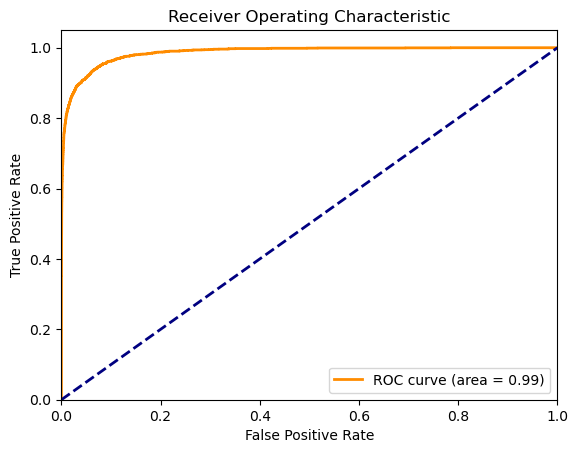

Complete


In [86]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
Y_pred_prob = Y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print('Complete')

<h2>Confusion Matrix</h2>

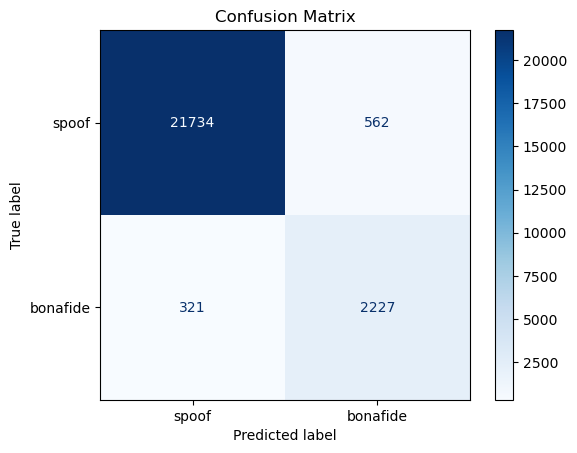

Complete


In [87]:
# CONFUSION MATRIX
cm = confusion_matrix(Y_test, Y_pred_classes)

# Display the confusion matrix
# "spoof" rappresent the negative class (0) and "bonafide" the positive class (1)
classes = ["spoof", "bonafide"]
#Create an object to visualize the matrix confusion with the labels of the class
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print('Complete')

<h2>Precision-Recall Curve</h2>

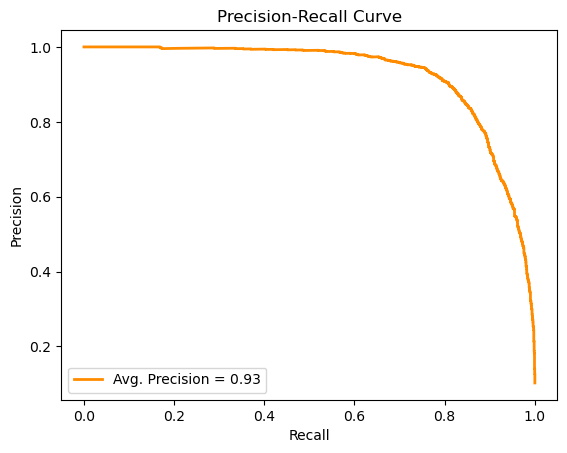

Complete


In [88]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_prob)
avg_precision = average_precision_score(Y_test, Y_pred_prob)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Avg. Precision = %0.2f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print('Complete')

<h2>Calibration Curve</h2>

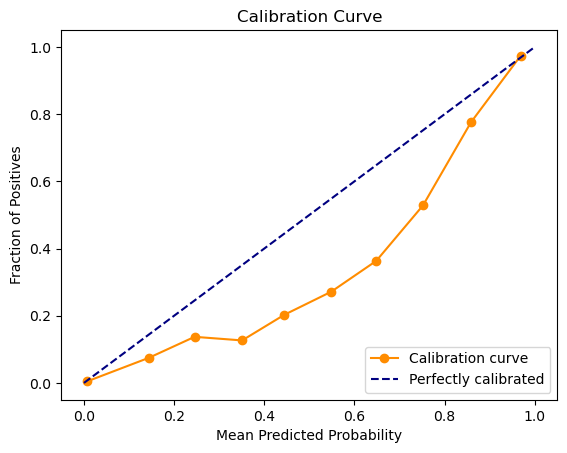

Complete


In [89]:
# Calibration Curve
from sklearn.calibration import calibration_curve

# Compute calibration curve
prob_true, prob_pred = calibration_curve(Y_test, Y_pred_prob, n_bins=10)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

print('Complete')

<h2>Classification Report</h2>

In [90]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Suppose that Y_test and Y_pred_prob are defined as array list
# Convert Y_test and Y_pred_prob in array NumPy
Y_test = np.array(Y_test)  

#plot classification report
report = classification_report(Y_test, Y_pred_classes,target_names=['spoof','bonafide'])
print(report)



              precision    recall  f1-score   support

       spoof       0.99      0.97      0.98     22296
    bonafide       0.80      0.87      0.83      2548

    accuracy                           0.96     24844
   macro avg       0.89      0.92      0.91     24844
weighted avg       0.97      0.96      0.97     24844



<h2>Class Bar Distribution</h2>

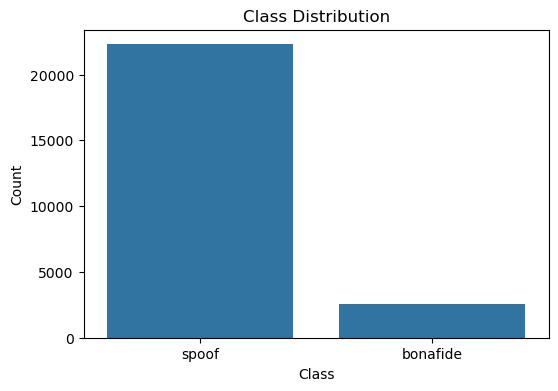

Complete


In [91]:
# Plot bar chart of class distribution

import seaborn as sns
import matplotlib.pyplot as plt


LABELS = ['spoof', 'bonafide']

plt.figure(figsize=(6, 4))
sns.countplot(x=Y_test)
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

print('Complete')

<h2>Model Summary</h2>

In [92]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
import pydot


model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file=MODEL_PATH.split('.')[0]+'.png')
print('Complete')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 109, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 107, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 107, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,144,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,489,864 (70.53 MB)

 Trainable params: 6,163,266 (23.51 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 12,326,534 (47.02 MB)

Complete


<h2>Visualizing Mel Spectrograms for Audio Files in the Dataset</h2>

In [ ]:
# Visualising Mel Spectrogram

import os
import librosa.display

# Folder containing .flac audio files
folder_path = TEST_DATASET_PATH

# Get a list of all .flac files in the folder
flac_files = [file for file in os.listdir(folder_path) if file.endswith(".flac")]


# Loop through each .flac file and visualize its Mel spectrogram
for flac_file in flac_files:
    audio_file_path = os.path.join(folder_path, flac_file)

    # Load the audio file using librosa
    audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Calculate the Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {flac_file}')
    plt.show()
    break

print('Complete')